# Notebook that uses the isaura output to check all the basic markers for a successful topological extraction of information.

- Apply all the required cuts
- Quantify the number of tracks vs track energy, blob 1 vs blob 2 energy, etc


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm

import functions_HE as func


In [2]:
def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'Tracking', 'Tracks')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}')
        x = pd.DataFrame()
        return x

    
    
    

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        
        particles       :       pandas.DataFrame
                                Concatenated DataFrame containing the /MC/particles data from all h5 files, with the 'event_id' column modified.

        eventmap        :       pandas.DataFrame
                                Concatenated DataFrame containing the event map from all h5 files.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    # Use ProcessPoolExecutor to parallelize the data loading process
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list = results

    # Concatenate all the dataframes at once
    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    return tracks

In [3]:
RUN_NUMBER = 15107
TIMESTAMP  = 130525

In [4]:
# whole thing
n100_dir = f'/gluster/data/next/files/TOPOLOGY_John/N100_data/{RUN_NUMBER}/isaura/{TIMESTAMP}/'

hdst = []

for i in tqdm(range(1,8)):
    print(f"LDC {i}")
    folder_path = n100_dir + 'ldc' + str(i) + '/'
    hdst.append(load_data_fast(folder_path))

hdst = pd.concat(hdst)

  0%|          | 0/7 [00:00<?, ?it/s]

LDC 1
File /gluster/data/next/files/TOPOLOGY_John/N100_data/15107/isaura/130525/ldc1/isaura_run_15107_0676_ldc1_130525.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /gluster/data/next/files/TOPOLOGY_John/N100_data/15107/isaura/130525/ldc1/isaura_run_15107_0876_ldc1_130525.h5 broke with error:
group ``/`` does not have a child named ``Tracking``


 14%|█▍        | 1/7 [00:08<00:51,  8.53s/it]

LDC 2


 29%|██▊       | 2/7 [00:18<00:47,  9.48s/it]

LDC 3


 43%|████▎     | 3/7 [00:26<00:35,  8.95s/it]

LDC 4
File /gluster/data/next/files/TOPOLOGY_John/N100_data/15107/isaura/130525/ldc4/isaura_run_15107_1355_ldc4_130525.h5 broke with error:
group ``/`` does not have a child named ``Tracking``


 57%|█████▋    | 4/7 [00:34<00:25,  8.49s/it]

LDC 5


 71%|███████▏  | 5/7 [00:43<00:16,  8.46s/it]

LDC 6


 86%|████████▌ | 6/7 [00:51<00:08,  8.48s/it]

LDC 7


100%|██████████| 7/7 [01:00<00:00,  8.60s/it]


In [5]:
display(hdst)
print(hdst.event.nunique())

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,6869,0,1.501006,160.891088,207,5781,1,293.625,-198.675,570.026250,...,580.255173,310.353851,-78.920172,667.765346,0.204574,0.203141,0.000000,10.416667,11.458333,11.863194
1,7345,0,2.354606,686.471028,573,14478,4,106.125,73.825,828.352500,...,833.241704,171.058335,333.815492,964.007875,0.562813,0.018786,0.000000,11.944444,11.778846,11.945270
2,7345,1,0.096289,28.554742,8,346,4,311.125,-241.175,1222.150625,...,1226.059319,329.749673,-209.279174,1237.839138,0.085741,0.067165,0.056617,11.944444,11.778846,11.945270
3,7345,2,0.019746,16.775308,2,47,4,233.625,196.325,266.171250,...,266.216497,242.625979,198.446151,269.473757,0.019746,0.019746,0.019746,11.944444,11.778846,11.945270
4,7345,3,0.000853,16.775308,2,20,4,408.625,186.325,964.007875,...,964.007875,418.822627,191.379167,964.007875,0.000853,0.000853,0.000853,11.944444,11.778846,11.945270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39950,2325819,3,0.025998,11.952498,2,71,6,-133.875,-271.175,-820.480375,...,-815.399345,-126.655951,-262.984068,-808.968563,0.025998,0.025998,0.025998,11.860465,11.911765,11.952498
39951,2325819,4,0.012478,11.860465,2,38,6,-116.375,256.325,1048.284000,...,1049.250616,-108.162917,260.943897,1049.905036,0.012478,0.012478,0.012478,11.860465,11.911765,11.952498
39952,2325819,5,0.001713,11.860465,2,8,6,-68.875,258.825,1088.482250,...,1088.482250,-61.375000,261.325000,1088.482250,0.001713,0.001713,0.001713,11.860465,11.911765,11.952498
39953,2325861,0,1.212898,177.410526,129,2995,1,176.125,106.325,24.474250,...,87.790698,183.733961,131.680128,28.679666,0.197095,0.183697,0.000000,12.000000,11.250000,11.521094


102902


In [6]:
import functions_HE as func

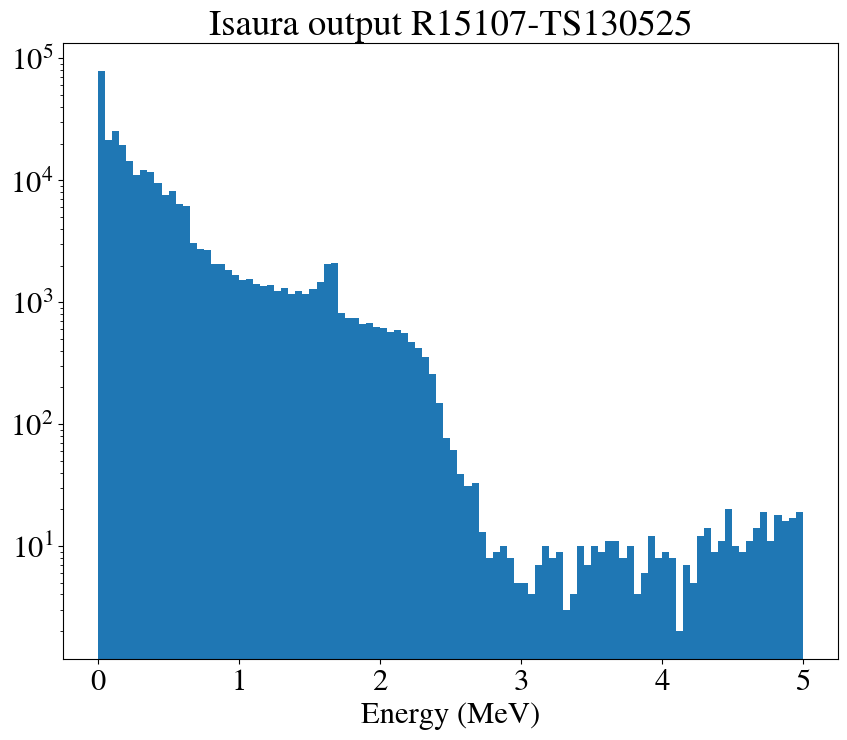

In [7]:
plt.hist(hdst.energy.values, range = (0,5), bins = 100)
plt.xlabel('Energy (MeV)')
plt.title(f'Isaura output R{RUN_NUMBER}-TS{TIMESTAMP}')
plt.yscale('log')

In [8]:
cut_hdst, efficiencies = func.apply_cuts(hdst, lower_z = 20, upper_z = 1195, r_lim = 472, lower_e = 1.5, upper_e = 1.7)

Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Fiducial track cut
Relative Cut efficiency:
Efficiency: 52.71 %
Absolute Cut efficiency:
Efficiency: 52.71 %
One track cut
Relative Cut efficiency:
Efficiency: 49.05 %
Absolute Cut efficiency:
Efficiency: 29.85 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 49.69 %
Absolute Cut efficiency:
Efficiency: 15.58 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.92 %
Absolute Cut efficiency:
Efficiency: 6.70 %


In [9]:
display(efficiencies)

,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,102902,100.000000
1,Fiducial Cuts,52.709374,54239,52.709374
2,One track cut,49.045889,26602,29.846845
3,Blob overlap cuts,49.691752,13219,15.577929
4,Energy cuts,10.916106,1443,6.703465


Text(0.5, 1.0, 'Isaura output R15107 post-cuts')

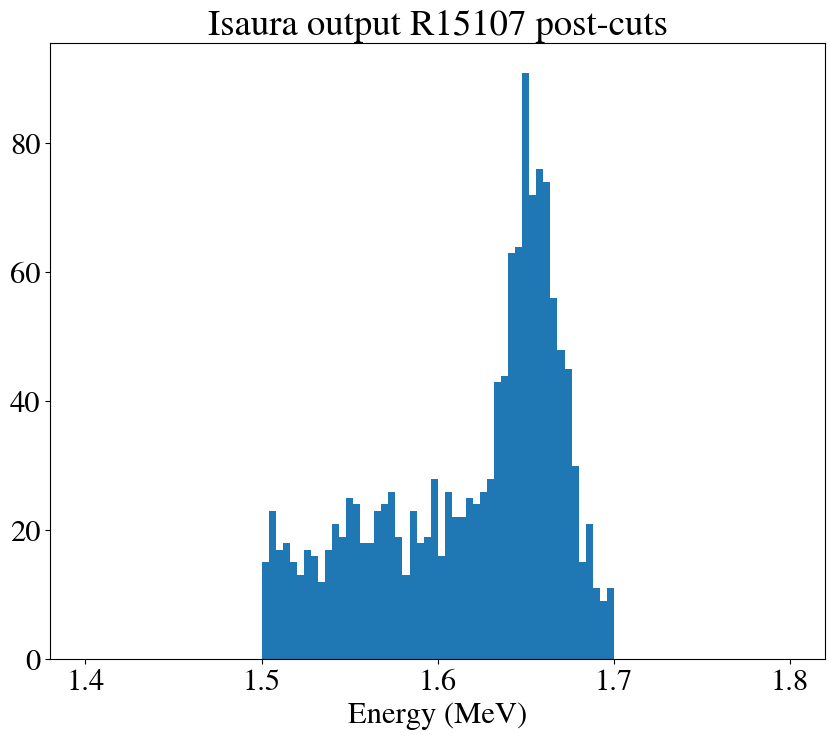

In [10]:
plt.hist(cut_hdst.energy.values, range = (1.4,1.8), bins = 100)
plt.xlabel('Energy (MeV)')
plt.title(f'Isaura output R{RUN_NUMBER} post-cuts')


In [11]:
display(hdst)
print(hdst.columns.values)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,6869,0,1.501006,160.891088,207,5781,1,293.625,-198.675,570.026250,...,580.255173,310.353851,-78.920172,667.765346,0.204574,0.203141,0.000000,10.416667,11.458333,11.863194
1,7345,0,2.354606,686.471028,573,14478,4,106.125,73.825,828.352500,...,833.241704,171.058335,333.815492,964.007875,0.562813,0.018786,0.000000,11.944444,11.778846,11.945270
2,7345,1,0.096289,28.554742,8,346,4,311.125,-241.175,1222.150625,...,1226.059319,329.749673,-209.279174,1237.839138,0.085741,0.067165,0.056617,11.944444,11.778846,11.945270
3,7345,2,0.019746,16.775308,2,47,4,233.625,196.325,266.171250,...,266.216497,242.625979,198.446151,269.473757,0.019746,0.019746,0.019746,11.944444,11.778846,11.945270
4,7345,3,0.000853,16.775308,2,20,4,408.625,186.325,964.007875,...,964.007875,418.822627,191.379167,964.007875,0.000853,0.000853,0.000853,11.944444,11.778846,11.945270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39950,2325819,3,0.025998,11.952498,2,71,6,-133.875,-271.175,-820.480375,...,-815.399345,-126.655951,-262.984068,-808.968563,0.025998,0.025998,0.025998,11.860465,11.911765,11.952498
39951,2325819,4,0.012478,11.860465,2,38,6,-116.375,256.325,1048.284000,...,1049.250616,-108.162917,260.943897,1049.905036,0.012478,0.012478,0.012478,11.860465,11.911765,11.952498
39952,2325819,5,0.001713,11.860465,2,8,6,-68.875,258.825,1088.482250,...,1088.482250,-61.375000,261.325000,1088.482250,0.001713,0.001713,0.001713,11.860465,11.911765,11.952498
39953,2325861,0,1.212898,177.410526,129,2995,1,176.125,106.325,24.474250,...,87.790698,183.733961,131.680128,28.679666,0.197095,0.183697,0.000000,12.000000,11.250000,11.521094


['event' 'trackID' 'energy' 'length' 'numb_of_voxels' 'numb_of_hits'
 'numb_of_tracks' 'x_min' 'y_min' 'z_min' 'r_min' 'x_max' 'y_max' 'z_max'
 'r_max' 'x_ave' 'y_ave' 'z_ave' 'r_ave' 'extreme1_x' 'extreme1_y'
 'extreme1_z' 'extreme2_x' 'extreme2_y' 'extreme2_z' 'blob1_x' 'blob1_y'
 'blob1_z' 'blob2_x' 'blob2_y' 'blob2_z' 'eblob1' 'eblob2'
 'ovlp_blob_energy' 'vox_size_x' 'vox_size_y' 'vox_size_z']


### track energies

Maximal number of tracks: 0        1
1        4
2        4
3        4
4        4
        ..
39950    6
39951    6
39952    6
39953    1
39954    1
Name: numb_of_tracks, Length: 277262, dtype: int64


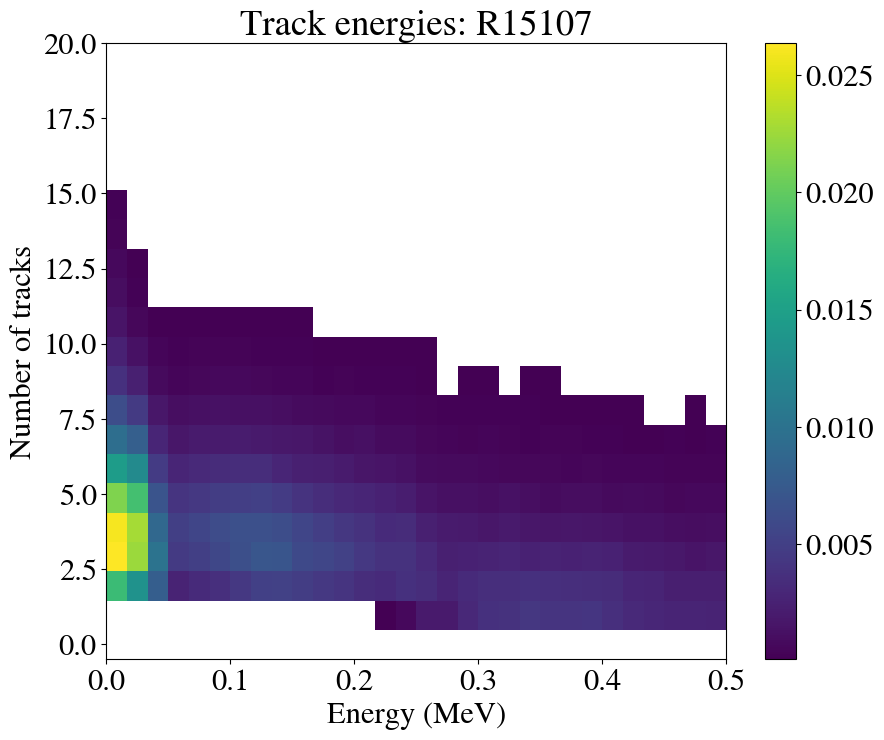

In [12]:
# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

track_energy = hdst.energy
track_no = hdst.numb_of_tracks
# normalise
print(f'Maximal number of tracks: {track_no}')
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(30, 21), cmin=0.0001, range = ((0,0.5),(-0.5,20)))
plt.title(f"Track energies: R{RUN_NUMBER}")
plt.colorbar()
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.show()

In [13]:
low_e_evts = hdst[hdst.energy < 0.05]
low_e_evts_ = hdst[hdst.energy < 0.05]

display(low_e_evts)
low_e_full = hdst[hdst['event'].isin(low_e_evts.event.values)]
display(low_e_full)
low_e_evts = low_e_full.event.unique()

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
3,7345,2,0.019746,16.775308,2,47,4,233.625,196.325,266.171250,...,266.216497,242.625979,198.446151,269.473757,0.019746,0.019746,0.019746,11.944444,11.778846,11.945270
4,7345,3,0.000853,16.775308,2,20,4,408.625,186.325,964.007875,...,964.007875,418.822627,191.379167,964.007875,0.000853,0.000853,0.000853,11.944444,11.778846,11.945270
19,13351,2,0.018866,11.111111,2,52,3,328.625,293.825,1387.014250,...,1390.613658,344.177475,302.219903,1391.538967,0.018866,0.018866,0.018866,11.111111,11.346154,11.858244
23,13491,3,0.042861,11.875000,2,102,4,258.625,-371.175,1193.239000,...,1196.311912,262.928633,-355.061327,1197.794163,0.042861,0.042861,0.042861,11.906780,11.875000,11.933112
27,2865,1,0.000242,0.000000,1,4,2,-36.375,-33.675,77.168250,...,77.168250,-35.048088,-32.461418,77.168250,0.000242,0.000242,0.000242,11.944444,10.833333,11.405359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39948,2325819,1,0.046571,11.911765,2,58,6,-98.875,276.325,1088.482250,...,1093.148045,-98.013508,293.500859,1088.655452,0.046571,0.046571,0.046571,11.860465,11.911765,11.952498
39949,2325819,2,0.043149,0.000000,1,75,6,341.125,301.325,-318.516750,...,-314.482879,345.382856,305.284041,-314.482879,0.043149,0.043149,0.043149,11.860465,11.911765,11.952498
39950,2325819,3,0.025998,11.952498,2,71,6,-133.875,-271.175,-820.480375,...,-815.399345,-126.655951,-262.984068,-808.968563,0.025998,0.025998,0.025998,11.860465,11.911765,11.952498
39951,2325819,4,0.012478,11.860465,2,38,6,-116.375,256.325,1048.284000,...,1049.250616,-108.162917,260.943897,1049.905036,0.012478,0.012478,0.012478,11.860465,11.911765,11.952498


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
1,7345,0,2.354606,686.471028,573,14478,4,106.125,73.825,828.352500,...,833.241704,171.058335,333.815492,964.007875,0.562813,0.018786,0.000000,11.944444,11.778846,11.945270
2,7345,1,0.096289,28.554742,8,346,4,311.125,-241.175,1222.150625,...,1226.059319,329.749673,-209.279174,1237.839138,0.085741,0.067165,0.056617,11.944444,11.778846,11.945270
3,7345,2,0.019746,16.775308,2,47,4,233.625,196.325,266.171250,...,266.216497,242.625979,198.446151,269.473757,0.019746,0.019746,0.019746,11.944444,11.778846,11.945270
4,7345,3,0.000853,16.775308,2,20,4,408.625,186.325,964.007875,...,964.007875,418.822627,191.379167,964.007875,0.000853,0.000853,0.000853,11.944444,11.778846,11.945270
17,13351,0,0.246762,43.107262,21,714,3,351.125,261.325,438.001375,...,448.280530,356.442793,296.071114,447.910999,0.204395,0.135660,0.093294,11.111111,11.346154,11.858244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39948,2325819,1,0.046571,11.911765,2,58,6,-98.875,276.325,1088.482250,...,1093.148045,-98.013508,293.500859,1088.655452,0.046571,0.046571,0.046571,11.860465,11.911765,11.952498
39949,2325819,2,0.043149,0.000000,1,75,6,341.125,301.325,-318.516750,...,-314.482879,345.382856,305.284041,-314.482879,0.043149,0.043149,0.043149,11.860465,11.911765,11.952498
39950,2325819,3,0.025998,11.952498,2,71,6,-133.875,-271.175,-820.480375,...,-815.399345,-126.655951,-262.984068,-808.968563,0.025998,0.025998,0.025998,11.860465,11.911765,11.952498
39951,2325819,4,0.012478,11.860465,2,38,6,-116.375,256.325,1048.284000,...,1049.250616,-108.162917,260.943897,1049.905036,0.012478,0.012478,0.012478,11.860465,11.911765,11.952498


In [14]:
spatial = ['x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave']
mins = spatial[0:4]
maxs = spatial[4:8]
avs  = spatial[9:]

print(mins)
print(maxs)
print(avs)
print(mins[0])
print(mins[1])

['x_min', 'y_min', 'z_min', 'r_min']
['x_max', 'y_max', 'z_max', 'r_max']
['y_ave', 'z_ave', 'r_ave']
x_min
y_min


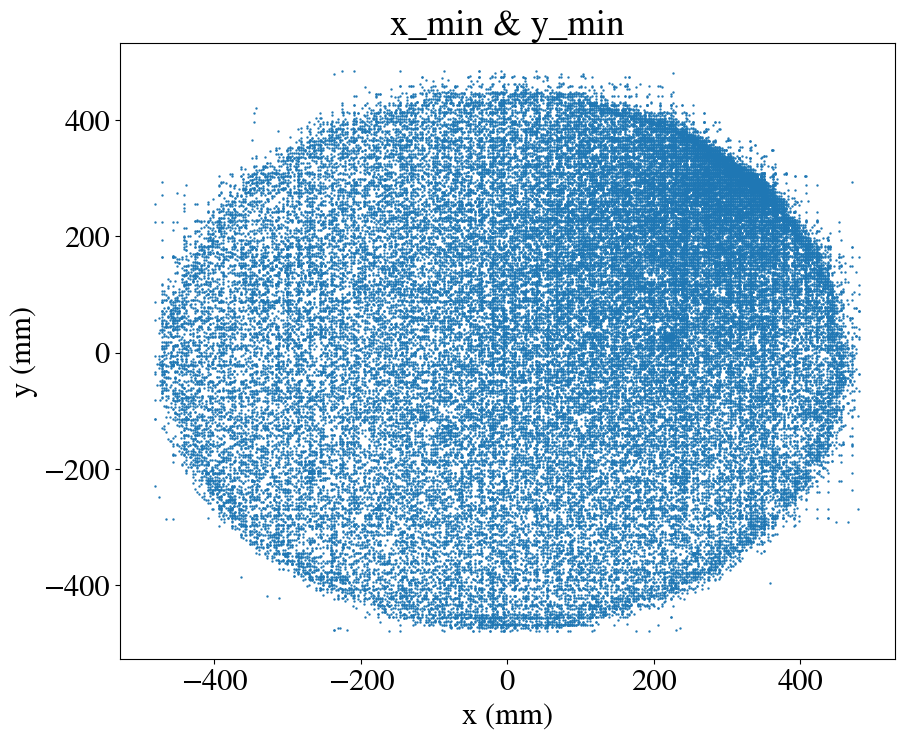

In [15]:
# xy
plt.scatter(low_e_evts_[f'{mins[0]}'].values, low_e_evts_[f'{mins[1]}'].values, s = 0.5)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title(f'{mins[0]} & {mins[1]}')
plt.show()

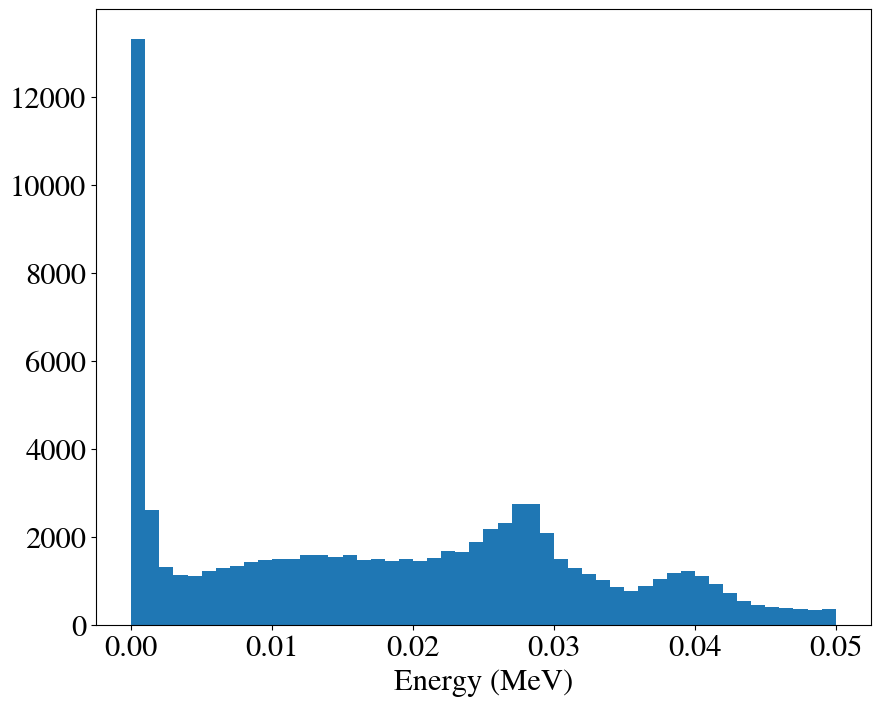

In [16]:
plt.hist(low_e_evts_.energy.values, bins = 50, range = (0, 0.05))
plt.xlabel('Energy (MeV)')
plt.show()

# If we eliminate all tracks below 50 keV?

In [17]:
clean_hdst = hdst[hdst.energy > 0.05]

In [18]:
cleancut_hdst, clean_efficiencies = func.apply_cuts(clean_hdst, lower_z = 20, upper_z = 1195, r_lim = 472, lower_e = 1.5, upper_e = 1.7)

Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Fiducial track cut
Relative Cut efficiency:
Efficiency: 59.24 %
Absolute Cut efficiency:
Efficiency: 59.24 %
One track cut
Relative Cut efficiency:
Efficiency: 64.15 %
Absolute Cut efficiency:
Efficiency: 44.08 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 51.63 %
Absolute Cut efficiency:
Efficiency: 24.69 %
Energy cut
Relative Cut efficiency:
Efficiency: 11.23 %
Absolute Cut efficiency:
Efficiency: 6.70 %


In [19]:
display(clean_efficiencies)

,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,102899,100.000000
1,Fiducial Cuts,59.244502,60962,59.244502
2,One track cut,64.151439,39108,44.084005
3,Blob overlap cuts,51.633937,20193,24.690230
4,Energy cuts,11.231615,2268,6.703661


Text(0.5, 1.0, 'Isaura output R15107 post-cuts - clean cut - rmax of 472mm')

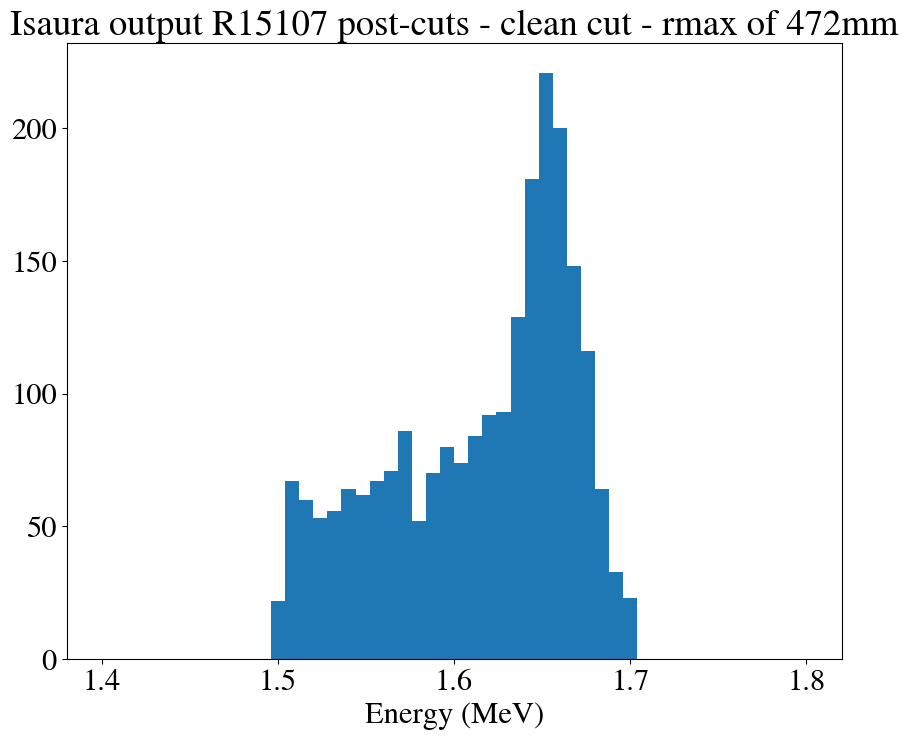

In [20]:
plt.hist(cleancut_hdst.energy.values, range = (1.4,1.8), bins = 50)
plt.xlabel('Energy (MeV)')
plt.title(f'Isaura output R{RUN_NUMBER} post-cuts - clean cut - rmax of 472mm')


In [21]:
def plot_volume_hists(df):

    func.plot_hist(df, column = 'x_min', output = False, label = 'x_min', fill = False, x_label = 'position (mm)')
    func.plot_hist(df, column = 'x_max', title = 'x plot for full volume', output = False, label = 'x_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    func.plot_hist(df, column = 'y_min', output = False, label = 'y_min', fill = False, x_label = 'position (mm)')
    func.plot_hist(df, column = 'y_max', title = 'y plot for full volume', output = False, label = 'y_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    func.plot_hist(df, column = 'z_min', output = False, label = 'z_min', fill = False, x_label = 'position (mm)')
    func.plot_hist(df, column = 'z_max', title = 'z plot for full volume', output = False, label = 'z_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()



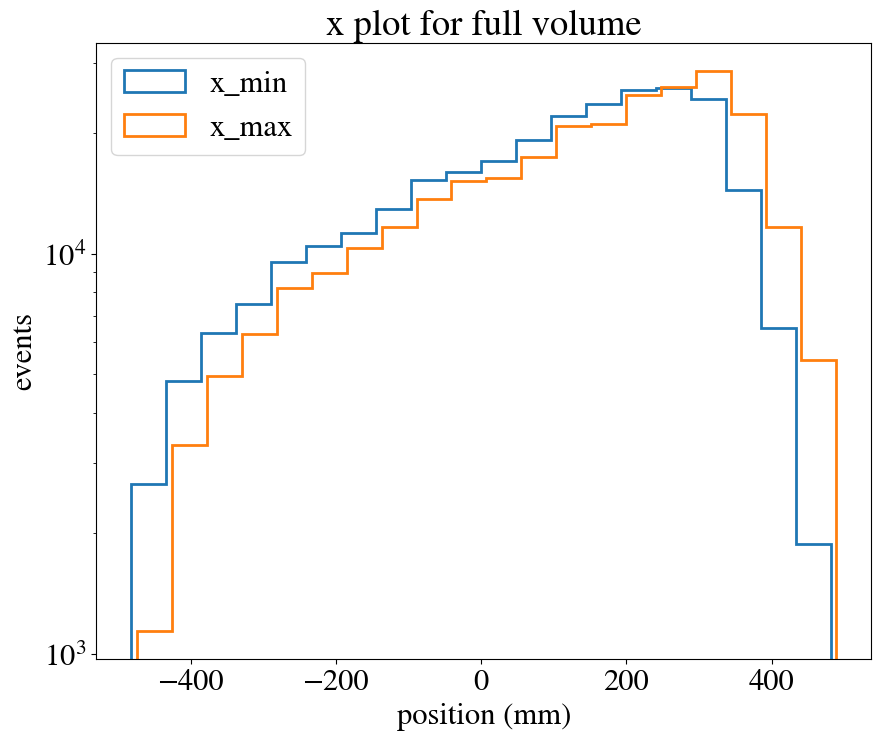

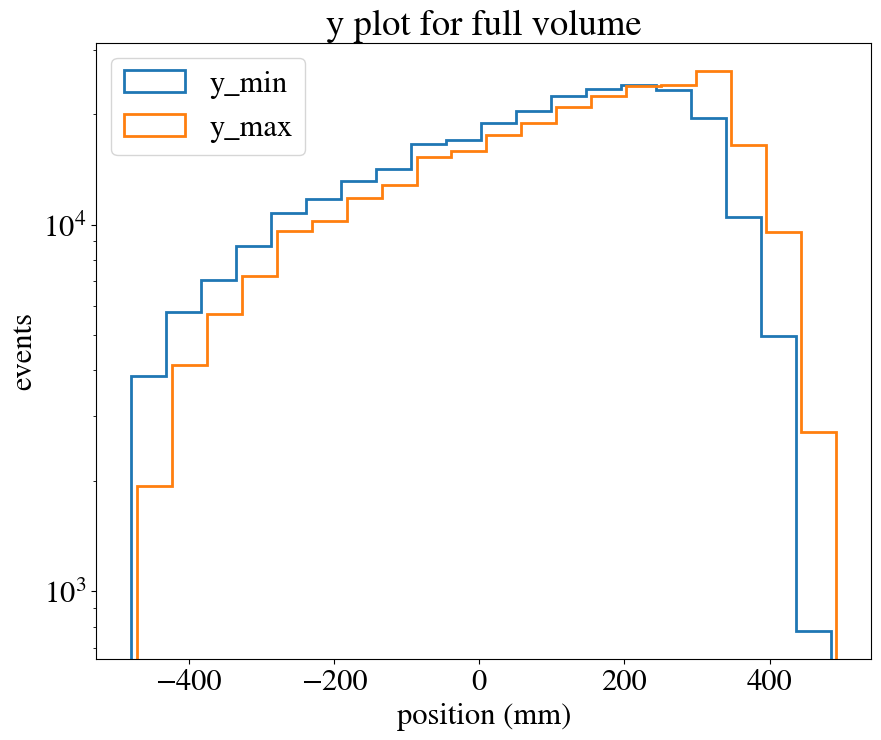

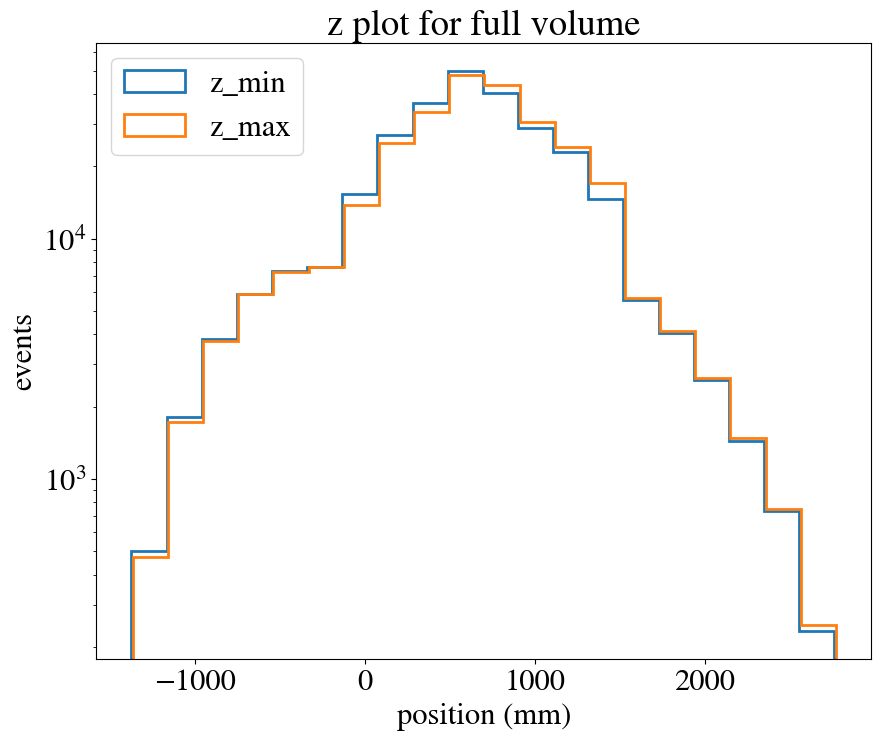

In [22]:
plot_volume_hists(hdst)

(array([ 2203.,  9638., 14871., 38852., 81648., 74147., 41033.,  9776.,
         4102.,   992.]),
 array([-1364.30223633,  -950.7098377 ,  -537.11743906,  -123.52504043,
          290.0673582 ,   703.65975684,  1117.25215547,  1530.8445541 ,
         1944.43695273,  2358.02935137,  2771.62175   ]),
 <BarContainer object of 10 artists>)

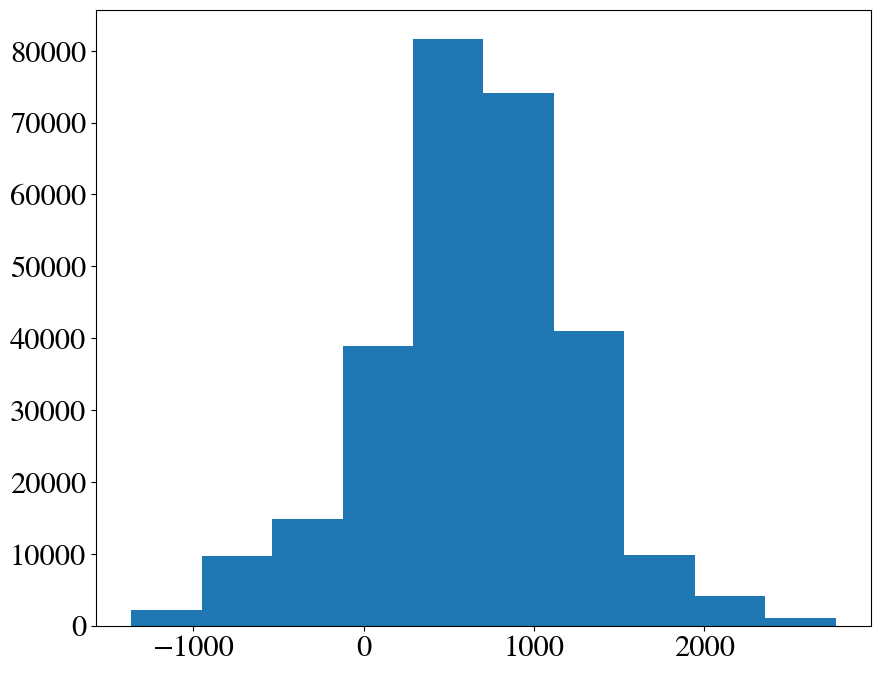

In [23]:
# crosscheck
plt.hist(hdst['z_max'].values) 

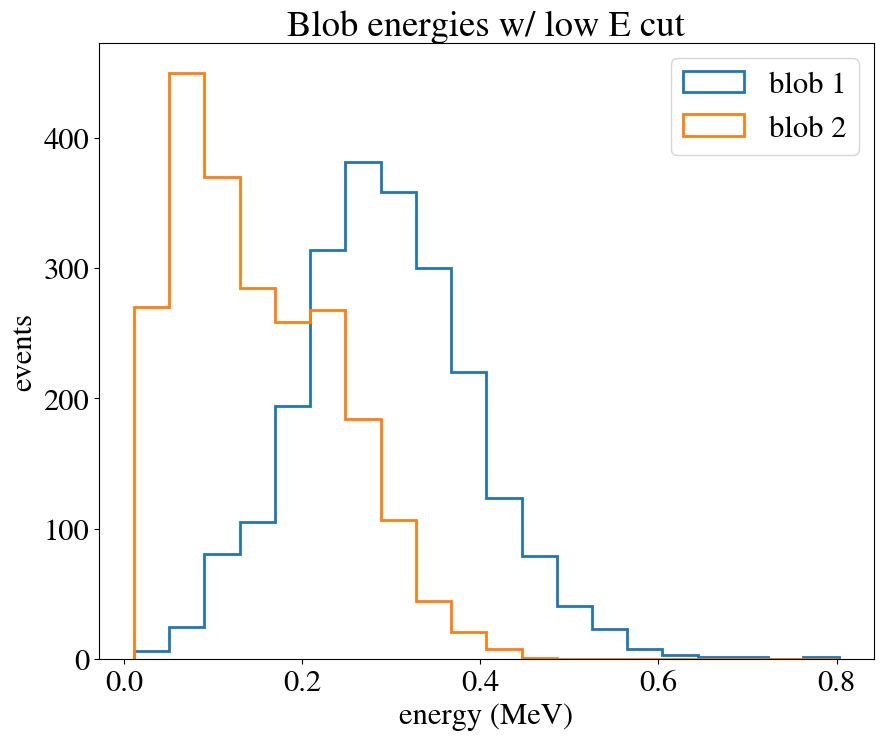

In [24]:
# make range full range of blob1 and blob2
eblob_full = []
eblob_full.append(cleancut_hdst['eblob1'].to_numpy())
eblob_full.append(cleancut_hdst['eblob2'].to_numpy())

minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)

func.plot_hist(cleancut_hdst, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
func.plot_hist(cleancut_hdst, column = 'eblob2', binning = 20, title = "Blob energies w/ low E cut", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
plt.legend()
plt.show()

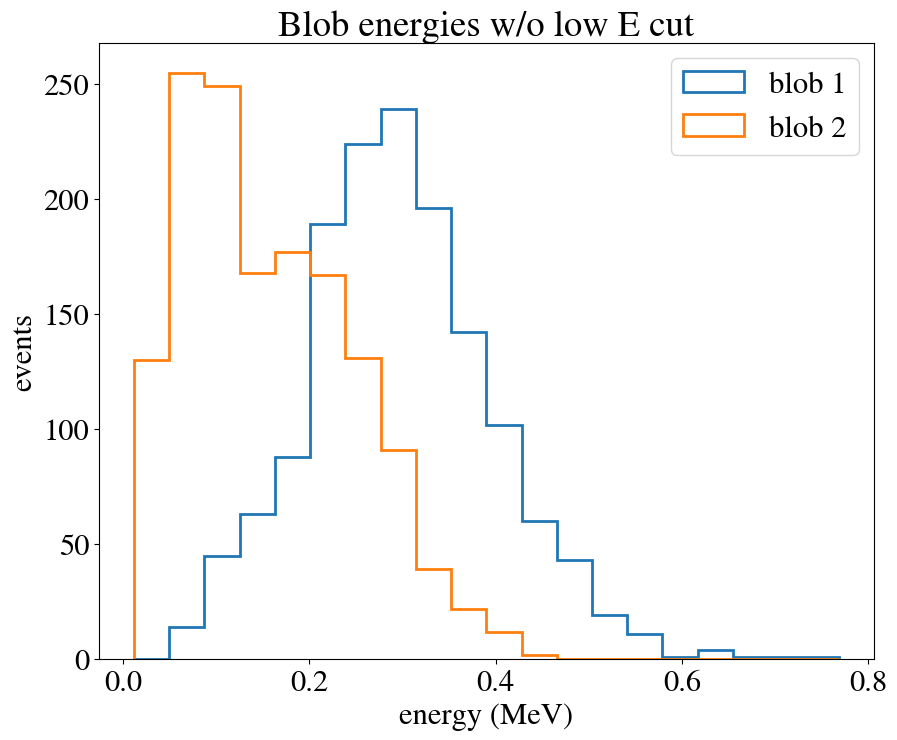

In [25]:
# make range full range of blob1 and blob2
eblob_full = []
eblob_full.append(cut_hdst['eblob1'].to_numpy())
eblob_full.append(cut_hdst['eblob2'].to_numpy())

minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)

func.plot_hist(cut_hdst, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
func.plot_hist(cut_hdst, column = 'eblob2', binning = 20, title = "Blob energies w/o low E cut", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
plt.legend()
plt.show()

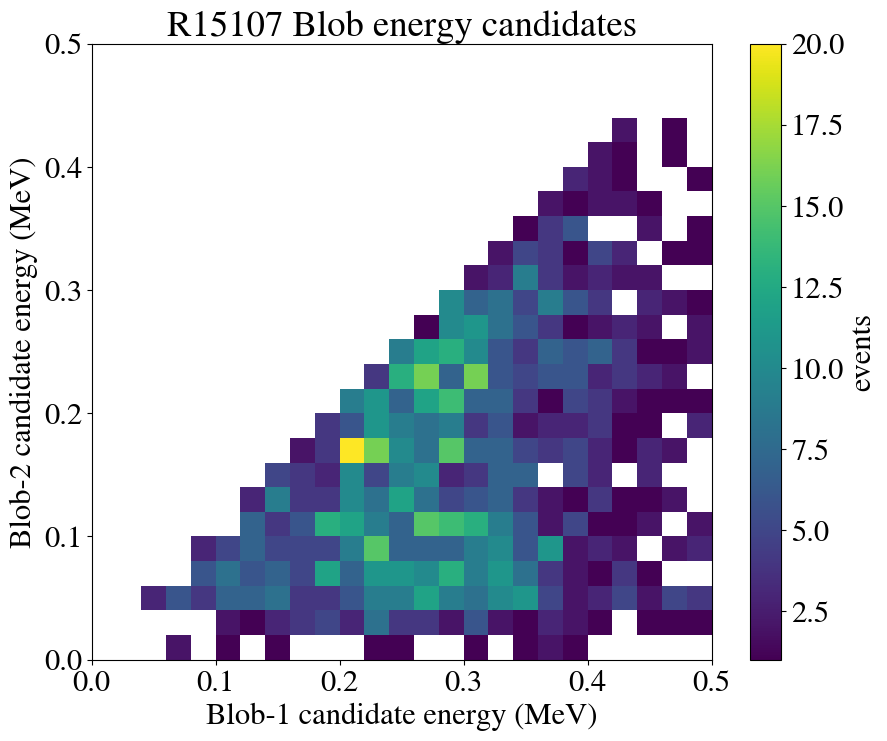

In [26]:
# blob 2dhist
plt.hist2d(cut_hdst['eblob1'], cut_hdst['eblob2'], bins=(25, 25), range=((0, 0.5), (0, 0.5)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title(f"R{RUN_NUMBER} Blob energy candidates")
plt.show()

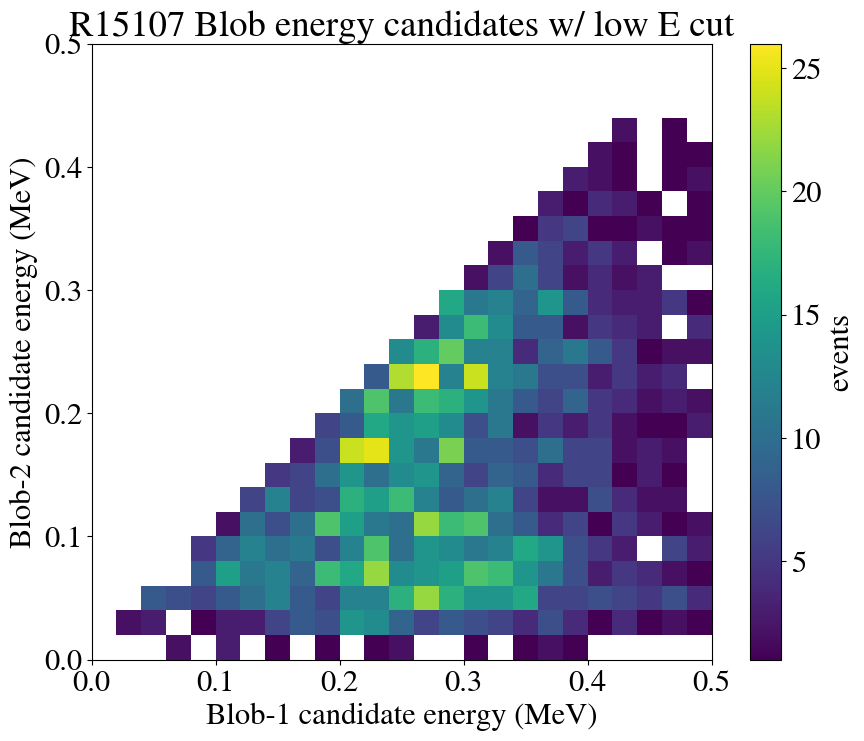

In [27]:
# blob 2dhist
plt.hist2d(cleancut_hdst['eblob1'], cleancut_hdst['eblob2'], bins=(25, 25), range=((0, 0.5), (0, 0.5)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title(f"R{RUN_NUMBER} Blob energy candidates w/ low E cut")
plt.show()